# Importing Libraries

In [1]:
import snscrape.modules.twitter as sntwitter #Used snscrape to pull old tweets
import pandas as pd
import numpy as np
import string

import re
import emoji
import requests

from collections import Counter
from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
from tqdm.notebook import tqdm

#from transformers import pipeline
#roberta_pipeline = pipeline('sentiment-analysis')

from textblob import TextBlob 
from textblob.sentiments import NaiveBayesAnalyzer
nav_bayes = NaiveBayesAnalyzer()

# Scraping Data Using Snscrape

In [2]:
# Creating list to append tweet data to
tweets_list = []

# Using TwitterSearchScraper to scrape data from 2022-05-05 till 2022-06-05 (1 month) and append tweets to list
for i,tweet in enumerate(sntwitter.TwitterSearchScraper('#BloodSisters since:2022-05-05 until:2022-06-05').get_items()):
    tweets_list.append([tweet.date, tweet.id, tweet.content, tweet.user.username, 
                         tweet.user.location, tweet.lang, tweet.retweetCount, tweet.likeCount])

In [3]:
df = pd.DataFrame(tweets_list, columns=['Datetime', 'Tweet Id', 'Text', 'Username', 'Location', 'Language',
                                               'Retweets', 'Likes'])

In [4]:
df.drop(columns = 'Username').head()

,Datetime,Tweet Id,Text,Location,Language,Retweets,Likes
0,2022-06-04 22:04:06+00:00,1533207993935970304,"I went in with no expectations and honestly, #...",🌍,en,0,2
1,2022-06-04 21:52:13+00:00,1533205005716570112,#BloodSisters a débarqué sur @Netflix alors qu...,Paris,fr,1,12
2,2022-06-04 18:57:24+00:00,1533161010789498883,Another Saturday night to tell you to watch BL...,Vormir to Nidavellir,en,0,6
3,2022-06-04 15:57:56+00:00,1533115848352833538,"Sometimes, when you're very close to someone y...",Abuja,en,0,4
4,2022-06-04 02:39:10+00:00,1532914831036231682,"Uncle @realwaleojo... Just after Phone Swap, y...","Lagos, Nigeria",en,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15352 entries, 0 to 15351
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype              
---  ------    --------------  -----              
 0   Datetime  15352 non-null  datetime64[ns, UTC]
 1   Tweet Id  15352 non-null  int64              
 2   Text      15352 non-null  object             
 3   Username  15352 non-null  object             
 4   Location  15352 non-null  object             
 5   Language  15352 non-null  object             
 6   Retweets  15352 non-null  int64              
 7   Likes     15352 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(3), object(4)
memory usage: 959.6+ KB


In [6]:
df['Language'].value_counts()

en     14186
fr       293
und      218
in       123
qme       91
qht       87
ht        72
tl        67
es        53
et        27
tr        27
de        18
ro        11
it        10
cy         8
hi         7
sl         7
pt         7
nl         5
sv         5
cs         4
ca         4
lt         3
vi         3
da         3
ur         3
ar         2
no         2
pl         2
eu         2
th         1
hu         1
Name: Language, dtype: int64

In [7]:
#Creating a dataframe to store only english tweets
tweets_df = df[df['Language'] == 'en']
tweets_df.reset_index(drop=True, inplace=True)

In [8]:
#For data privacy, the usernames were changed
tweets_df['Username'] = tweets_df['Username'].apply(lambda x: x[::2] + x[::-1])

C:\Users\queency\AppData\Local\Temp/ipykernel_10256/2675876012.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df['Username'] = tweets_df['Username'].apply(lambda x: x[::2] + x[::-1])


## Location

In [9]:
#Creating a location dataframe to store top 50 location values
location_df = pd.DataFrame(tweets_df.loc[:, 'Location'].value_counts().head(50))\
                .reset_index()\
                .reset_index()\
                .rename(columns={'level_0':'id', 'index':'location', 'Location':'counts'})

In [10]:
#Here api was used to get the city and country values
URL = "https://geocoder.ls.hereapi.com/search/6.2/geocode.json"
api_key = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'  # Acquire api key from developer.here.com

def getCoordinates(location):
    PARAMS = {'searchtext': location, 'apikey': api_key} # required parameters
    r = requests.get(url=URL, params=PARAMS)  # pass in required parameters
    data = r.json() # Raw json file
    try:
        label = data['Response']['View'][0]['Result'][0]['Location']['Address']['City']
        country = data['Response']['View'][0]['Result'][0]['Location']['Address']['Country']
        return label, country
    except:
        return 'Unknown', 'Unknown'

#You can also use geopy to do this
#from geopy.geocoders import Nominatim
#from geopy.extra.rate_limiter import RateLimiter
#import geopy
 
# calling the nominatim tool
#geopy.geocoders.options.default_user_agent = "GetLoc"
#loc = Nominatim(user_agent="GetLoc")
#geocode = RateLimiter(loc.geocode, min_delay_seconds=0)

In [11]:
#Tqdm was used for the progress bar and the result is stored in the hereloc dictionary
hereloc = {}

for i, row in tqdm(location_df.iterrows(), total=len(location_df), miniters=1):    
    myid = row['id']
    locate = row['location']
    
    label, country_code = getCoordinates(locate)
    #country_code = geocode(locate) --Like stated above, geocode can also be used
    hereloc[myid] = [label, country_code]

  0%|          | 0/50 [00:00<?, ?it/s]

In [12]:
location_dict = pd.DataFrame.from_dict(hereloc, orient='index')\
                .reset_index()\
                .rename(columns={'index': 'id', 0: 'city', 1: 'country_code'})

location_data = location_df.merge(location_dict)

In [13]:
#Extracting top country and city from the location_data dataframe
country_count = location_data.groupby('country_code').sum()[['counts']].sort_values('counts', ascending=False).reset_index()
city_count = location_data.groupby('city').sum()[['counts']].sort_values('counts', ascending=False).reset_index()

Text(0, 1, 'Country Code')

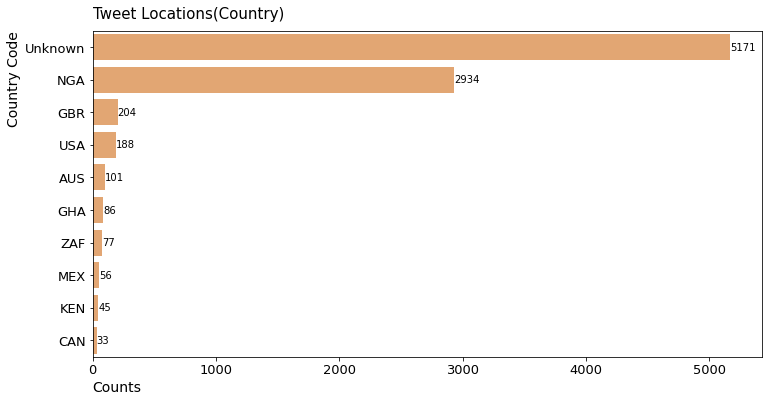

In [14]:
with plt.rc_context({'font.size':13}):
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='counts', y='country_code', data = country_count, color='sandybrown')
    
plt.bar_label(ax.containers[0])
ax.set_title('Tweet Locations(Country)', fontdict={'fontsize':15}, loc='left', pad = 12)
ax.set_xlabel('Counts', fontdict={'fontsize':14}, loc='left')
ax.set_ylabel('Country Code', fontdict={'fontsize':14}, loc='top')

Text(0, 1, 'City')

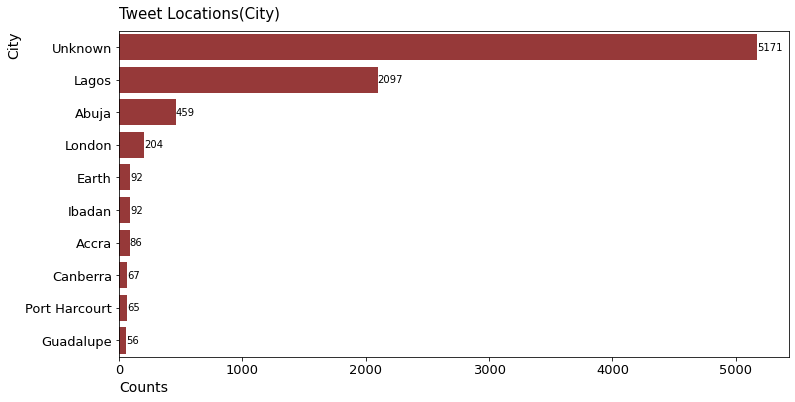

In [15]:
with plt.rc_context({'font.size':13}):
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='counts', y='city', data = city_count.head(10), color='brown')
    
plt.bar_label(ax.containers[0])
ax.set_title('Tweet Locations(City)', fontdict={'fontsize':15}, loc='left', pad=12)
ax.set_xlabel('Counts', fontdict={'fontsize':14}, loc='left')
ax.set_ylabel('City', fontdict={'fontsize':14}, loc='top')

## Hashtags, Mentioned Users, Characters

In [16]:
#A function to extract hashtags from a tweet
def hashtags(tweet):
    tweet = tweet.lower()
    tweet_regex = re.findall(r'#\w+', tweet)
    return ' '.join(tweet_regex)

In [17]:
#A function to extract mentioned users from a tweet
def mentions(tweet):
    tweet = tweet.lower()
    tweet_regex = re.findall(r'@\w+', tweet)
    return ' '.join(tweet_regex)

In [18]:
bloodsisters_character = ['kola', 'uduak', 'uchenna', 'kemi', 'sarah', 'femi', 'uncle b', 'olayinka', 'yinka', 'joe', 
                          'abasiama', 'abby', 'timeyin', 'tijano', 'akin', 'ifeanyi', 'kenny', 'princess', 'blade', 
                         'adeboye', 'chicago']

In [19]:
#A function to extract series characters from a tweet
def characters(tweet):
    tweet = tweet.lower()
    tweet_tokenize = word_tokenize(tweet)
    xter = [character for character in tweet_tokenize if character in bloodsisters_character]
    return ' '.join(xter)

In [20]:
tweets_df.loc[:, 'Hashtags'] = tweets_df.loc[:, 'Text'].apply(hashtags)
tweets_df.loc[:, 'MentionedUsers'] = tweets_df.loc[:, 'Text'].apply(mentions)
tweets_df.loc[:, 'Characters'] = tweets_df.loc[:, 'Text'].apply(characters)

C:\Users\queency\AppData\Local\Temp/ipykernel_10256/3578459749.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df.loc[:, 'Hashtags'] = tweets_df.loc[:, 'Text'].apply(hashtags)
C:\Users\queency\AppData\Local\Temp/ipykernel_10256/3578459749.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df.loc[:, 'MentionedUsers'] = tweets_df.loc[:, 'Text'].apply(mentions)
C:\Users\queency\AppData\Local\Temp/ipykernel_10256/3578459749.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy 

In [21]:
tweets_df.head()

,Datetime,Tweet Id,Text,Username,Location,Language,Retweets,Likes,Hashtags,MentionedUsers,Characters
0,2022-06-04 22:04:06+00:00,1533207993935970304,"I went in with no expectations and honestly, #...",CMneednoMLC,🌍,en,0,2,#bloodsisters,,
1,2022-06-04 18:57:24+00:00,1533161010789498883,Another Saturday night to tell you to watch BL...,Imaoieimoya_maI,Vormir to Nidavellir,en,0,6,#bloodsistersnetflix #bloodsisters,@genovevaumeh,
2,2022-06-04 15:57:56+00:00,1533115848352833538,"Sometimes, when you're very close to someone y...",WnifeIGIderfeinniW,Abuja,en,0,4,#bloodsisters,@realwaleojo,chicago
3,2022-06-04 02:39:10+00:00,1532914831036231682,"Uncle @realwaleojo... Just after Phone Swap, y...",imlxybdedabeyoxelamai,"Lagos, Nigeria",en,0,0,#bloodsisters,@realwaleojo,
4,2022-06-03 21:08:17+00:00,1532831560696733697,#bloodsisters on God's mind that year..😜\nChil...,XtqNqitoX,,en,0,1,#bloodsisters,,


In [22]:
#A function used to count hashtags, mentioned users and characters
def count(terms):
    terms = str(terms)
    term_list = tweets_df[terms].tolist()
    tweet_list = []

    for term in term_list:
        items = term.split()
        for item in items:
            tweet_list.append(item)
        
    term_count = Counter(tweet_list)
    term_count_df = pd.DataFrame.from_dict(term_count, orient='index').reset_index()
    term_count_df.columns = [terms, 'Count']
    term_count_df.sort_values('Count', ascending=False, inplace=True)
    term_count_df.reset_index(inplace=True, drop='True')
    
    tweet_string = ' '.join(tweet_list)
    
    #Returns a dataframe (consisting of values and counts) and a string containing the values
    return term_count_df, tweet_string

### Top Hashtags

In [23]:
hash_count_df, hash_string = count('Hashtags')

In [24]:
hash_count_df.head(10)

,Hashtags,Count
0,#bloodsisters,14274
1,#bloodsistersnetflix,2476
2,#endasuustrike,282
3,#netflix,246
4,#netflixnaija,142
5,#lagosswindlers,135
6,#bbnaijareunion,115
7,#nollywood,104
8,#scammers,103
9,#asuu,94


Text(0.5, 1.0, 'Blood Sisters HashTags')

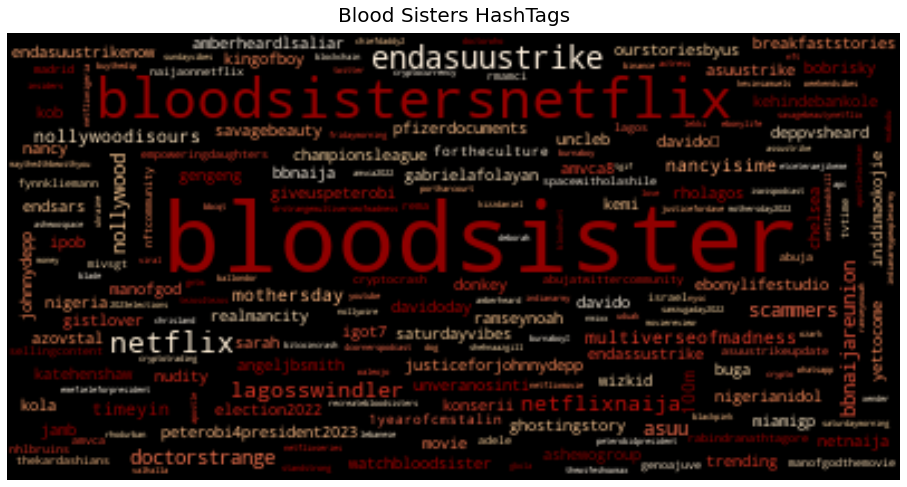

In [25]:
hash_wc = WordCloud(background_color='black', collocations=False)

#Generate the word cloud
hash_wc.generate(hash_string)

#Display the word cloud
fig = plt.figure(figsize=(16, 18))

plt.imshow(hash_wc.recolor(colormap='OrRd', random_state=2), alpha=1, 
           interpolation="bilinear")
plt.axis('off')
plt.title('Blood Sisters HashTags', fontdict={'fontsize':20}, pad=12)

## Top Mentioned Character

In [26]:
character_count_df, character_string = count('Characters')

In [27]:
character_count_df.head(10)

,Characters,Count
0,kemi,643
1,kola,614
2,timeyin,614
3,sarah,594
4,femi,236
5,kenny,209
6,uduak,205
7,chicago,183
8,yinka,116
9,blade,106


Text(0, 1, 'Characters')

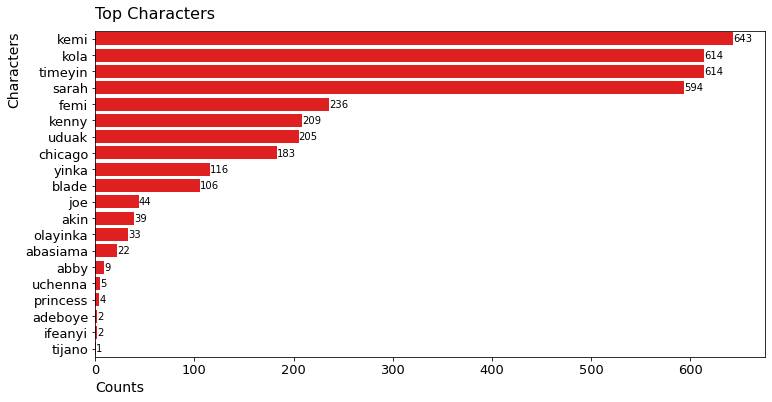

In [28]:
with plt.rc_context({'font.size':13}):
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='Count', y='Characters', data=character_count_df, color = 'red')
    
plt.bar_label(ax.containers[0])
ax.set_title('Top Characters', fontdict={'fontsize':16}, loc='left', pad=12)
ax.set_xlabel('Counts', fontdict={'fontsize':14}, loc= 'left')
ax.set_ylabel('Characters', fontdict={'fontsize':14}, loc = 'top')

## Mentioned Users

In [29]:
mentions_count_df, mentions_string = count('MentionedUsers')
mentions_count_df.head(10)

,MentionedUsers,Count
0,@henshawkate,623
1,@damiadenuga,428
2,@genovevaumeh,277
3,@netflixnaija,246
4,@_deyemi,153
5,@gabbylucciii,142
6,@uchejombo,115
7,@inidimaokojie,101
8,@_kehindebankole,98
9,@moabudu,98


Text(0, 1, 'Users')

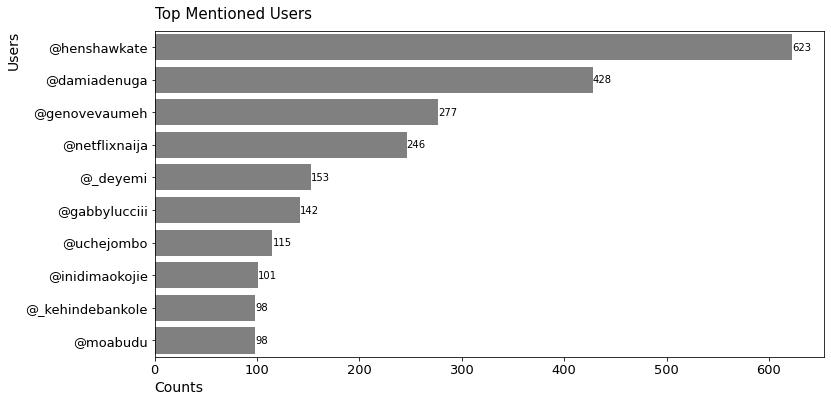

In [30]:
with plt.rc_context({'font.size':13}):
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='Count', y='MentionedUsers', data = mentions_count_df.head(10), color='gray')
    
plt.bar_label(ax.containers[0])
ax.set_title('Top Mentioned Users', fontdict={'fontsize':15}, loc='left', pad=12)
ax.set_xlabel('Counts', fontdict={'fontsize':14}, loc='left')
ax.set_ylabel('Users', fontdict={'fontsize':14}, loc='top')

## Top Words 

In [31]:
nltk_stopwords = list(stopwords.words('english'))
common_words = ['netflix', '2020', '2021','year','aht', 've', 'next',"'ll","n't", "'s",'anyone','today',
                'yesterday','day', 'already', "'re", 'uncle', "'m'", "'", '...', '....', 'blood', 'sisters', 'sister',
               "''", "'officer", "chicago'", '..', ',', '’']

stop_words = nltk_stopwords + common_words + bloodsisters_character #inlcuding coomon words and characters into stopwords

word_count = []
tweet = tweets_df['Text'].tolist()
for word in tweet:
    word = word.lower()
    word = re.sub(r'http\S+|www\S+', '', word, flags = re.MULTILINE) #removing links
    word = re.sub(r'@\S+|#\S+', '', word, flags = re.MULTILINE) #removing mentioned users and hashtgas
    word = emoji.demojize(word)
    word = re.sub(r':\w+:', '', word, flags = re.MULTILINE) #removing emojis
    
    word_tokens = word_tokenize(word)
    tokenized_word = [word for word in word_tokens if word not in stop_words] #removing stopwords
    cleaned_word = [word for word in tokenized_word if word not in string.punctuation] #remoivng punctuations
    lemma = WordNetLemmatizer()
    root_word = [lemma.lemmatize(word) for word in cleaned_word] #using lemmatizer to find the root word of words
    word_count.append(root_word)
    
word_string = '-'.join(item for word in word_count for item in word)

In [32]:
#Creating the top words dataframe
word_counter = Counter(word_string.split("-"))
word_count_df = pd.DataFrame.from_dict(word_counter, orient='index').reset_index()
word_count_df.columns = ['Word', 'Count']
word_count_df.sort_values('Count', ascending=False, inplace=True)
word_count_df.reset_index(inplace=True, drop='True')

word_count_df.head(10)

,Word,Count
0,movie,1940
1,like,1189
2,one,982
3,good,900
4,watch,862
5,love,757
6,role,684
7,see,656
8,watching,592
9,really,589


Text(0.5, 1.0, 'Blood Sisters Top Words')

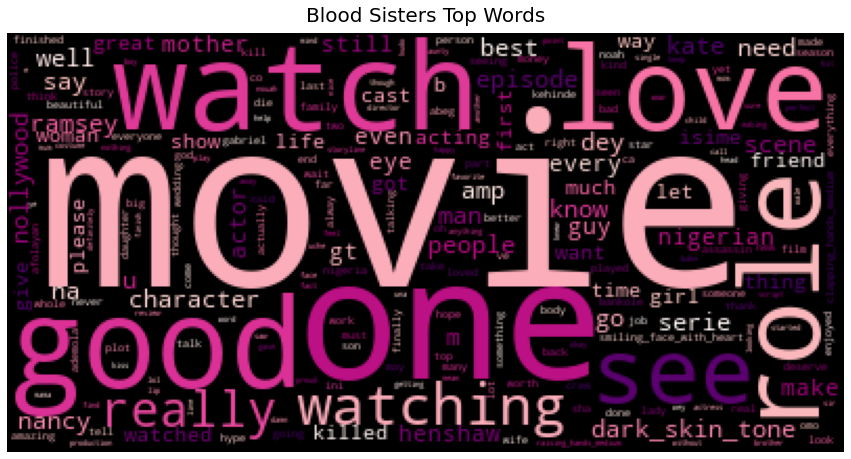

In [33]:
word_wc = WordCloud(background_color='black', max_words=250, collocations=False)

#Generate the word cloud
word_wc.generate(word_string)

#Display the word cloud
fig = plt.figure(figsize=(15, 16))
plt.imshow(word_wc.recolor(colormap='RdPu'), alpha=1)
plt.axis('off')
plt.title('Blood Sisters Top Words', fontdict={'fontsize':20}, pad=12)

## Sentiment Analysis using Vader, TextBlob using PatternAnalyzer and TextBlob using NaiveBayesAnalyzer

In [34]:
#Function to remove links from tweets
def processingTweet(tweet):
    tweet = re.sub(r'http\S+|www\S+', '', tweet, flags = re.MULTILINE)
    return tweet

In [35]:
tweets_df.loc[:, 'ProcessedText'] = tweets_df.loc[:,'Text'].apply(processingTweet)

C:\Users\queency\AppData\Local\Temp/ipykernel_10256/2024593860.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df.loc[:, 'ProcessedText'] = tweets_df.loc[:,'Text'].apply(processingTweet)


In [36]:
tweets_df.head()

,Datetime,Tweet Id,Text,Username,Location,Language,Retweets,Likes,Hashtags,MentionedUsers,Characters,ProcessedText
0,2022-06-04 22:04:06+00:00,1533207993935970304,"I went in with no expectations and honestly, #...",CMneednoMLC,🌍,en,0,2,#bloodsisters,,,"I went in with no expectations and honestly, #..."
1,2022-06-04 18:57:24+00:00,1533161010789498883,Another Saturday night to tell you to watch BL...,Imaoieimoya_maI,Vormir to Nidavellir,en,0,6,#bloodsistersnetflix #bloodsisters,@genovevaumeh,,Another Saturday night to tell you to watch BL...
2,2022-06-04 15:57:56+00:00,1533115848352833538,"Sometimes, when you're very close to someone y...",WnifeIGIderfeinniW,Abuja,en,0,4,#bloodsisters,@realwaleojo,chicago,"Sometimes, when you're very close to someone y..."
3,2022-06-04 02:39:10+00:00,1532914831036231682,"Uncle @realwaleojo... Just after Phone Swap, y...",imlxybdedabeyoxelamai,"Lagos, Nigeria",en,0,0,#bloodsisters,@realwaleojo,,"Uncle @realwaleojo... Just after Phone Swap, y..."
4,2022-06-03 21:08:17+00:00,1532831560696733697,#bloodsisters on God's mind that year..😜\nChil...,XtqNqitoX,,en,0,1,#bloodsisters,,,#bloodsisters on God's mind that year..😜\nChil...


In [37]:
tweets_df = tweets_df.reset_index().rename(columns={'index':'id'})

In [38]:
#Performing sentiment analysis on the processed tweets
res = {}

for i, row in tqdm(tweets_df.iterrows(), total=len(tweets_df)):
    text = row['ProcessedText']
    myid = row['id']
   
    vader_result = sia.polarity_scores(text)['compound']
    if vader_result >= 0.05:
        vader_sentiment = 'pos'
    elif vader_result <= -0.05:
        vader_sentiment = 'neg'
    else:
        vader_sentiment = 'neu'
        
    text_blob = TextBlob(text).sentiment.polarity
    if text_blob >= 0:
        blob_sentiment = 'pos'
    elif text_blob == 0:
        blob_sentiment = 'neu'
    else:
        blob_sentiment = 'neg'
    
    text_blob_nav = TextBlob(text, analyzer=nav_bayes).sentiment.classification
    blob_subject = TextBlob(text).sentiment.subjectivity
    
    sentiments = [vader_result, vader_sentiment, text_blob, blob_sentiment, text_blob_nav, blob_subject]
    res[myid] = sentiments

  0%|          | 0/14186 [00:00<?, ?it/s]

In [39]:
#Converting the result into a dataframe
sentiment_df = pd.DataFrame.from_dict(res, orient='index').rename(
    columns={0: 'vader_score', 1:'vader_sentiment', 2:'text_blob',3: 'blob_sentiment', 
             4: 'text_blob_naivebayes', 5:'subjectivity'})

sentiment_df = sentiment_df.reset_index().rename(columns={'index':'id'})

In [40]:
sentiment_df.tail(10)

,id,vader_score,vader_sentiment,text_blob,blob_sentiment,text_blob_naivebayes,subjectivity
14176,14176,0.3182,pos,0.000000,pos,pos,0.000000
14177,14177,0.5994,pos,0.350000,pos,pos,0.400000
14178,14178,0.5160,pos,0.500000,pos,pos,1.000000
14179,14179,-0.7227,neg,-0.077778,neg,pos,0.344444
14180,14180,0.9856,pos,0.400000,pos,pos,0.533333
14181,14181,0.8360,pos,0.000000,pos,neg,0.000000
14182,14182,0.3612,pos,0.150000,pos,pos,0.300000
14183,14183,0.3353,pos,-0.250000,neg,pos,0.500000
14184,14184,0.2500,pos,-0.077778,neg,pos,0.144444
14185,14185,-0.2732,neg,0.237500,pos,pos,0.750000


In [41]:
#Combining the sentiment dataframe with the tweets dataframe
combined_df = tweets_df.merge(sentiment_df)

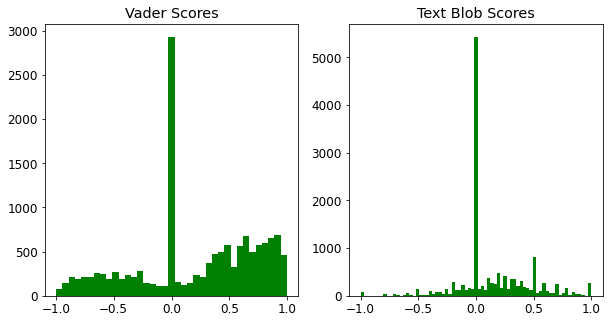

In [42]:
with plt.rc_context({'font.size': 12}):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax = ax1.hist(combined_df['vader_score'], bins='fd', color='g')
    axe2 = ax2.hist(combined_df['text_blob'], bins='fd', color='g')

    ax1.set_title('Vader Scores')
    ax2.set_title('Text Blob Scores')

The above charts show that while there were more positive sentiments majority of scores were in the 0.0 - 0.1 range

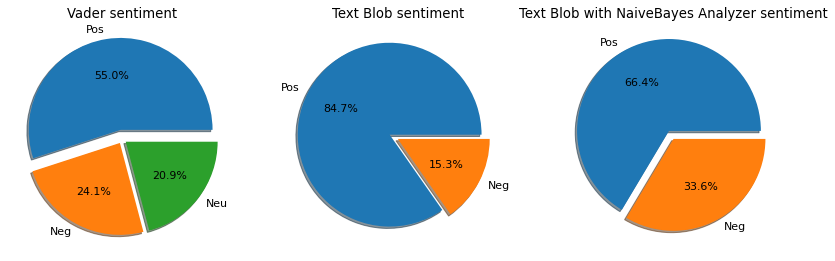

In [43]:
with plt.rc_context({'font.size': 11}):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 13))
    ax = ax1.pie(combined_df['vader_sentiment'].value_counts(), explode=[.1, 0.05, 0.05], labels=['Pos', 'Neg', 'Neu'], 
           autopct='%1.1f%%', shadow=True)
    axe2 = ax2.pie(combined_df['blob_sentiment'].value_counts(), explode=[.1, 0], labels=['Pos', 'Neg'], 
           autopct='%1.1f%%', shadow=True)
    axe3 = ax3.pie(combined_df['text_blob_naivebayes'].value_counts(), explode=[.1, 0], labels=['Pos', 'Neg'], 
           autopct='%1.1f%%', shadow=True)

    ax1.set_title('Vader sentiment')
    ax2.set_title('Text Blob sentiment')
    ax3.set_title('Text Blob with NaiveBayes Analyzer sentiment')

## Saving

In [44]:
#Storing and saving to csv files
location_data.iloc[:, [0, 3, 4, 2]].to_csv('location.csv')
combined_df.to_csv('sentiments.csv')
hash_count_df[hash_count_df['Count'] > 20].to_csv('hashtags.csv')
character_count_df.to_csv('character.csv')
mentions_count_df[mentions_count_df['Count'] > 10].to_csv('mentioned_users.csv')